In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sms
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import normaltest

In [2]:
data = pd.read_csv('hw_bootstrap.csv', delimiter = ';')

In [3]:
data.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
data.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
data.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [6]:
data.dtypes

value                object
experimentVariant    object
dtype: object

In [7]:
data['value'] = data.value.str.replace(',', '.')

In [8]:
data.head()

,value,experimentVariant
0,10.3804953740268,Control
1,9.54686666784264,Control
2,11.0882146509904,Control
3,10.1472740570122,Control
4,9.78980767524929,Control


In [9]:
data['value'] =  data.value.astype('float')

In [10]:
data.dtypes

value                float64
experimentVariant     object
dtype: object

In [21]:
Test = data.query("experimentVariant == 'Treatment'").value
Control = data.query("experimentVariant == 'Control'").value

In [12]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(np.mean(samples_1)-np.mean(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = sms.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = sms.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

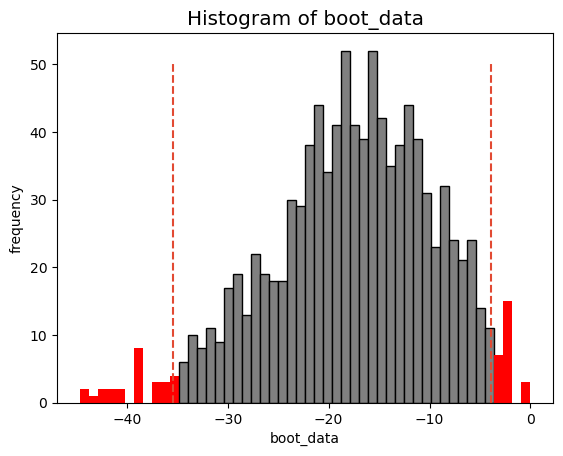

{'boot_data': [-6.0400928291884135,
  -38.92966907801015,
  -10.903878861244054,
  -24.284793480667695,
  -15.701621867903489,
  -17.951396986742967,
  -14.25545293245823,
  -18.2690784845566,
  -18.848298492210176,
  -31.933543070988776,
  -9.94902063885606,
  -41.53689532252993,
  -25.218661254217288,
  -21.698970650928494,
  -13.779676982298577,
  -16.94760814602136,
  -10.002583447497253,
  -29.212363770791526,
  -8.923487436317648,
  -6.071353708475682,
  -31.33583269091735,
  -29.839853672738545,
  -5.903745689452359,
  -15.208769032003485,
  -31.07927686438662,
  -10.734445795002785,
  -25.99359447828794,
  -42.39613796741646,
  -13.21411244748045,
  -12.926039586989534,
  -11.93510540006431,
  -9.949860144827882,
  -9.321397537897791,
  -10.963362381290997,
  -15.934364950905586,
  -18.343572124737108,
  -15.8718330138231,
  -26.84424707261622,
  -1.931412170432118,
  -22.890982421587772,
  -26.229554500979784,
  -16.37562480051455,
  -9.013382464175214,
  -7.940179149274599,
 

In [13]:
get_bootstrap(Control, Test)

Хочу посмотреть на форму распеределения самих значений в тествой и контрольно группе

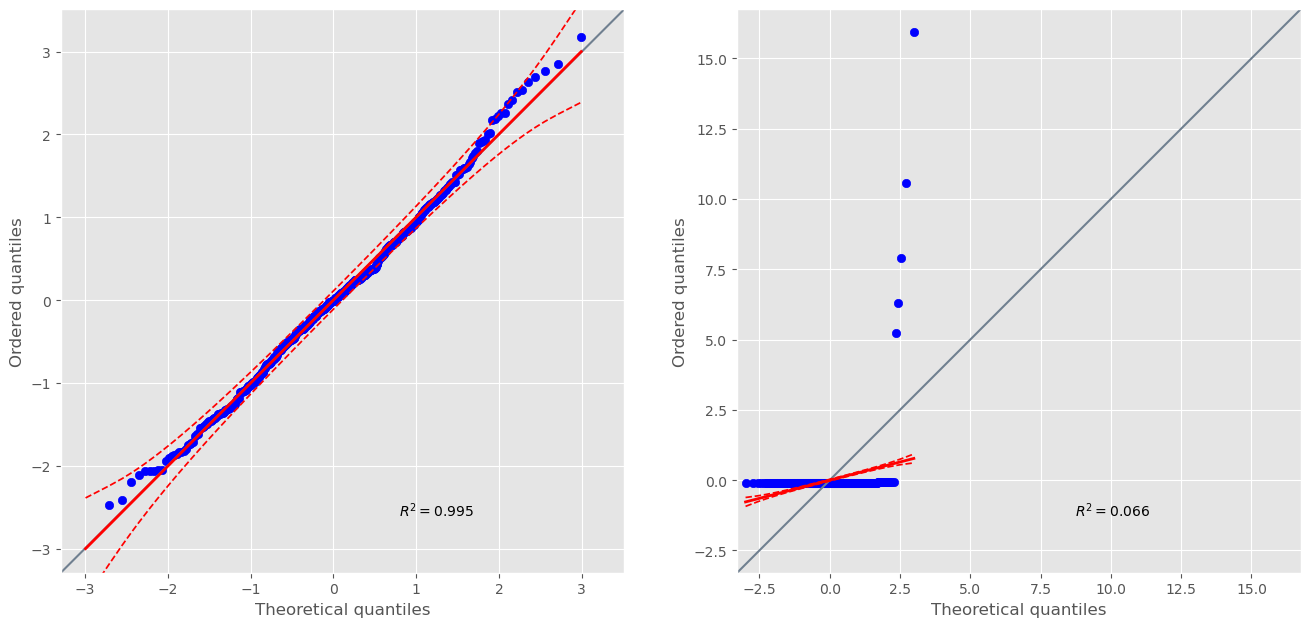

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1 = pg.qqplot(Control, ax=ax1)
ax2 = pg.qqplot(Test, ax=ax2)
plt.show()

выглядит будто в тестовой группе есть несколько значительных выбросов

In [15]:
data.query("experimentVariant == 'Treatment'").value.tail(10)

990      10.916229
991      11.160869
992       8.202518
993       9.782199
994      10.484967
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, dtype: float64

In [16]:
#так же проверим распределения на нормальность с помощью статистических функций
print('Test group ',normaltest(Test))

print('Control group ',normaltest(Control))

Test group  NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)
Control group  NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)


Результат теста на тестовой группе говорит, что, вероятно, данные распределены ненормально (pvalue очень маленький,есть основание отлонить нулевую гипотезу о том, что выборка взята из нормального распределения)

Изветно, что для применения t-test очень желательным условием является нормальность распределения. Контрольная группа имеет заметные выбросы и normaltest утверждает, что распределение ненормальное. Тем не менее, применим t-test и посмотрим какой результат он покажет

In [17]:
ttest_ind(Control, Test)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

pvalue ниже 0,05, что дает основание отклонить Н0, но мы помним о ненормальности выборки и больших выбросах, поэтому применим еще Мана-Уитни

In [18]:
mannwhitneyu(Control, Test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

pvalue=0.85 выглядит как слишком экстремальным

In [20]:
#Попробуем еще провести эксперимент без этих 5 последних экстремальных значений
Test2 = data.query("experimentVariant == 'Treatment'").value.head(495)

In [23]:
ttest_ind(Control, Test2)

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

In [24]:
mannwhitneyu(Control, Test2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

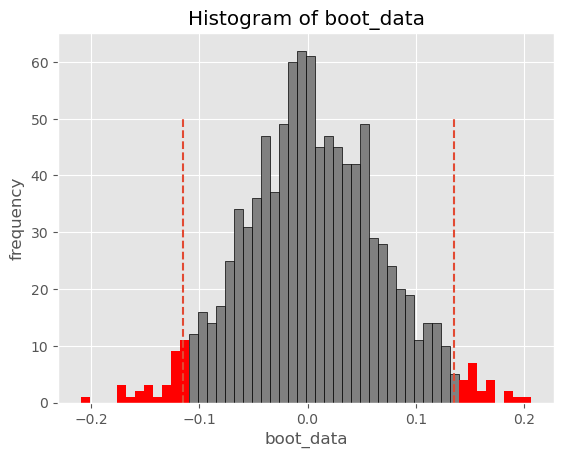

{'boot_data': [0.0013210197208746166,
  0.0023539435422943455,
  -0.015162064133063424,
  -0.026647069349223784,
  0.09427422297108201,
  -0.04272945484492929,
  -0.0022149150425310182,
  0.019401972253467292,
  -0.0692494436402935,
  -0.028280120118889585,
  -0.06491234855126926,
  0.03728796316964811,
  0.030604927347416933,
  -0.15812230177509967,
  -0.041466892158661395,
  0.0612544382727922,
  0.042616056812969205,
  -0.08227280462926245,
  0.09830127708312197,
  0.15141845418186684,
  -0.01903302693962594,
  -0.024285832619439063,
  -0.08148509045045671,
  0.07126980919292691,
  -0.029859764860049154,
  0.07716485299014053,
  0.03533584181753113,
  -0.06308139744191443,
  0.02923822820907951,
  -0.008604189628476533,
  0.028692452034210447,
  -0.019215806955095616,
  -0.02546397372504927,
  -0.008632027577105461,
  0.07402784043732247,
  -0.07030332225366998,
  -0.057619794485475495,
  0.05694450841582466,
  0.03687995456500559,
  -0.09122970490477655,
  -0.07516787444123985,
  -

In [25]:
get_bootstrap(Control, Test2)

Значение pvalue для всех 3х экспериментов намного выше порога.

____


##### T-test и bootstrap на полной тестовой выборке дает уровень pvalue, хоть и ниже 0,05, но, все равно, на грани порога. Манн-Уитни показывает значительное повышение pvalue <br>
##### Все 3 метода на тестовой выборке без 5ти последних значительных выбросов показывают приблизительно один уровень pvalue, который не дает оснвание отклонить нудевую гипотезу<br>

#### В качестве вывода: Я бы предложил, для начала, изучить природу этих 5 выбросов, что это такое? Откуда взялись такие большие цифры? не может ли это быть ошибкой в данных. Если есть возможность, то продолжить эксперимент и посмотреть на цифры. Мое предположение, что цифры в 1000, 1500 и 3000 являются или случайностью, которая не отражает тенденцию или ошибкой в данных. <br>

####   На данном этапе, не считаю возможным отклонить H0 об отсутсвии различий